

# IMPORTING LIBRARIES


In [1]:
import pandas as pd
import numpy as np
from google.colab import drive
drive.mount('/content/drive')
import re
!pip install -q wordcloud
!pip install torchmetrics
import wordcloud

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

# nltk.download('wordnet')
# nltk.download('punkt')
# nltk.download('averaged_perceptron_tagger') 
# nltk.download('omw-1.4')
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from IPython.core.display import Path
from gensim.scripts.glove2word2vec import glove2word2vec
import torch
import torch.nn as nn
from torchvision import datasets 
from torchvision.transforms import ToTensor
import torch.nn.functional as F 
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import random
import os
os.environ['PYTHONHASHSEED'] = str(69)
from sklearn.metrics import classification_report, RocCurveDisplay, roc_curve, auc
from sklearn.metrics import f1_score as skf1
from torchmetrics.functional import f1_score
from torchmetrics import ConfusionMatrix

Mounted at /content/drive
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 512 kB 14.0 MB/s 


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
#pass the paths here
testpath = '/content/drive/My Drive/AI2/HW3/imdb-reviews.csv'
modelpath = '/content/drive/My Drive/AI2/HW3/myNN.pt'
dftest = pd.read_csv(testpath,  sep='\t', lineterminator='\n')

In [5]:

dftest['review'] = dftest['review'].apply(lambda r: re.sub(r'\'', '', r))   #removing apostrophes so don't becomes dont
dftest['review'] = [r.lower() for r in dftest['review'] ]   #making everything lowercase
dftest['review'] = dftest['review'].apply(lambda r: re.sub(r'<br /><br />', ' ', r))  #removing this wierd sequence found in some reviews
dftest['review'] = dftest['review'].apply(lambda r: re.sub(r'[^a-z]', ' ', r))   #only keeping letters
rem = stopwords.words('english')
dftest['review'] = dftest['review'].apply(lambda r: ' '.join([word for word in r.split() if word not in rem]))

In [6]:
def vectorize(df, w2v):
	X = list()
	Y = list()
	# Scored are either positive or negative
	Scores = list(df['rating'].apply(lambda r: 1 if r > 5 else 0))

	for (i, review) in enumerate(df["review"].values):
		wvectors = list()
		for word in review.split(" "):
			if word in w2v.keys(): # Keeping only words in the vocabulary and using theur value
				wvectors.append(list(w2v[word]))
		if len(wvectors) > 0:
			X.append(np.mean(wvectors, axis=0)) #we keep the mean 
			Y.append(Scores[i])
	return (X,Y)

In [7]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove*.zip

--2022-12-23 17:46:24--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-12-23 17:46:25--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-12-23 17:46:25--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [8]:
w2v = {}

with open('glove.6B.300d.txt', encoding="utf8") as fp:
	for lines in fp:
		varray = lines.split(" ")
		w2v[varray[0]] = np.asarray(varray[1:], dtype='float32')

(Xtest, Ytest) = vectorize(dftest, w2v)

# CREATING SETS

In [9]:
XT = torch.tensor(Xtest, dtype=torch.float, device=device)
YT = torch.tensor(Ytest, device=device)
print(XT.shape, YT.shape)


torch.Size([45008, 300]) torch.Size([45008])


<ipython-input-9-07fb55d86dd9>:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  XT = torch.tensor(Xtest, dtype=torch.float, device=device)


# MODEL CREATION


In [10]:
class RNN(nn.Module):
    def __init__(self, cell_type,input_size, hidden_size, num_layers, drop, device, output_size, attention, num_heads, skip=False):
        super(RNN, self).__init__()
        
        cells = {
        "LSTM"    : nn.LSTM,
        "GRU"     : nn.GRU}
        
        self.cell_type = cell_type
        self.attention = attention
        self.hidden_size = hidden_size
        self.num_layers=num_layers
        self.skip= skip
        self.dropout = nn.Dropout(drop)
        if skip:
            self.rnn = nn.ModuleList()
            self.rnn.append(cells[cell_type](input_size=input_size, hidden_size=hidden_size, num_layers=1, batch_first=True, bidirectional=True, device=device))
            for i in range(num_layers-1):
                self.rnn.append(cells[cell_type](input_size=hidden_size*2, hidden_size=hidden_size, num_layers=1, batch_first=True,  bidirectional=True, device=device))
        else:
            self.rnn = cells[cell_type](input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True, dropout=drop, bidirectional=True, device=device)
        
#         Attention
        if self.attention:
            self.Q = nn.Linear(hidden_size*2,hidden_size*2, bias=False, device=device)
            self.K = nn.Linear(hidden_size*2,hidden_size*2, bias=False, device=device)
            self.V = nn.Linear(hidden_size*2,hidden_size*2, bias=False, device=device)
            self.att = nn.MultiheadAttention(self.hidden_size*2, num_heads=num_heads ,batch_first=True, device=device)

        
        self.out = nn.Linear(2*hidden_size, output_size, device=device)
        
    def forward(self, x):
        if self.skip:
            if self.cell_type == 'LSTM':
                r_out, (h_n, h_c) = self.rnn[0](x) 
            else:
                r_out, h_n = self.rnn[0](x)
                
            for i in range(self.num_layers-1):
                prev = r_out
                r_out = self.dropout(r_out)
                if self.cell_type == 'LSTM':
                    r_out, (h_n, h_c) = self.rnn[i+1](r_out) 
                else:
                    r_out, h_n = self.rnn[i+1](r_out)
                r_out = r_out + prev
        else:
            if self.cell_type == 'LSTM':
                r_out, (h_n, h_c) = self.rnn(x) 
            else:
                r_out, h_n = self.rnn(x)
                
        if self.attention:
            Q = self.Q(r_out)
            K = self.K(r_out)
            V = self.V(r_out)
            att, _ = self.att(Q, K, V)
            out = att + r_out 
        else:
            out = r_out
        return self.out(out) 
        

In [13]:
def train(model, epochs, dataloader, learningrate, Xval, Yval, prinntTF, clip):
    lastf1 = None
    lastmodel = None
    lossfunction = nn.CrossEntropyLoss()
    optim = torch.optim.Adam(model.parameters(), lr=learningrate)
    for ep in range(epochs):
        model.train()
        for batch, (X,Y) in enumerate(dataloader):
            optim.zero_grad()
            X = X.to(device)
            Y = Y.to(device)
            Ypred = model(X)
            l = lossfunction(Ypred, Y)
            l.backward()
            
            nn.utils.clip_grad_norm_(model.parameters(), clip)
            
            optim.step()
        with torch.no_grad():
            model.eval()
            _, Vpred = torch.max(model(Xval), 1)
            f1 = f1_score(Yval.cpu(), Vpred.cpu(), average="weighted", num_classes=2, task="multiclass")
            if prinntTF:
                print(f"for epoch = {ep} we got loss = {l.item()} and f1 score with val set = {f1}")
            if lastf1 is None:
                lastf1 = f1 
                lastmodel = model
            else:
                if lastf1 > f1:
                    return lastmodel
                else:
                    lastf1 = f1
    return model

def test(model, Xtest, Ytest):
    with torch.no_grad():
        model.eval()
        _, Ypred = torch.max(model(Xtest), 1)
        Ypred = Ypred.cpu()
        Ytest = Ytest.cpu()
        print(classification_report(Ytest, Ypred))
        return f1_score(Ytest, Ypred, average="weighted", num_classes=2, task="multiclass")

# TESTING

In [14]:
model = RNN("LSTM",  300, 16,3,0.375, device, 2,False, 7)
model.load_state_dict(torch.load(modelpath))
test(model, XT, YT)

              precision    recall  f1-score   support

           0       0.82      0.87      0.84     22500
           1       0.86      0.81      0.83     22508

    accuracy                           0.84     45008
   macro avg       0.84      0.84      0.84     45008
weighted avg       0.84      0.84      0.84     45008



tensor(0.8387)

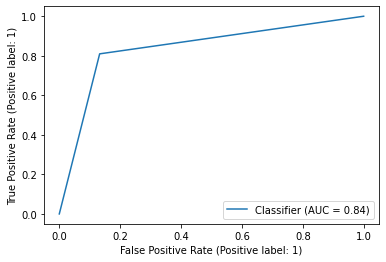

In [15]:
def plotROC(model, Xtest, Ytest):
	with torch.no_grad():
		model.eval()
		_, Ypred = torch.max(model(Xtest), 1)
		Ypred = Ypred.cpu()
		Ytest = Ytest.cpu()
		RocCurveDisplay.from_predictions(Ytest, Ypred)
		plt.show()
plotROC(model, XT, YT)